In [3]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import autograd
import numpy as np
import pickle as p
import mxnet as mx
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [4]:
def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

train_pic, train_label, test_pic, test_label = load_cifar()

In [5]:
batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)

In [6]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

In [7]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(10))
net.initialize(ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.005})

E 0; L 2.267094; Tr_acc 0.152677; Te_acc 0.205400; T 12.176303
E 20; L 1.664466; Tr_acc 0.413079; Te_acc 0.410799; T 0.891317
E 40; L 1.499415; Tr_acc 0.471344; Te_acc 0.457575; T 0.817115
E 60; L 1.394859; Tr_acc 0.505267; Te_acc 0.483881; T 0.893886
E 80; L 1.319931; Tr_acc 0.532393; Te_acc 0.494264; T 0.860407
E 100; L 1.232226; Tr_acc 0.565121; Te_acc 0.512856; T 0.957260
E 120; L 1.221603; Tr_acc 0.568554; Te_acc 0.515922; T 0.972678
E 140; L 1.214804; Tr_acc 0.571471; Te_acc 0.516218; T 1.053972


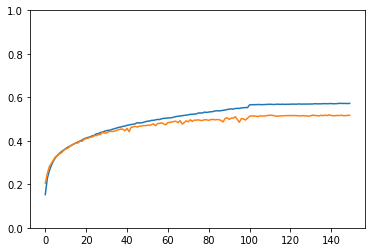

In [8]:
epochs = 150
lr_period = 100
lr_decay = 0.1

a = []
b = []
for epoch in range(epochs):
    if epoch > 0 and epoch % lr_period == 0:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%20 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()

In [2]:
32*32*3

3072